<a href="https://colab.research.google.com/github/Shubhranshu-Malhotra/Tensorflow-Developer-ZTM/blob/main/Food_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision

This project involves using transfer learning with fine tuning and mixed precision to perform multi class classification.  
The dataset we use was obtained from kaggle.  
It contains 1000 images (training: 750, testing: 250) of food belonging to 101 different classes.  
  
    

Goal:  
To beat [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment), a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.  

> 🔑 **Note:** **Top-1 accuracy** means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but top-1 means only the highest one is evaluated). **Top-5 accuracy** means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.


Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the speed of our model training:
1. Prefetching
2. Mixed precision training

## This project includes:

* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (**making our datasets run fast**)
* Creating modelling callbacks
* Setting up **mixed precision training**
* Building a feature extraction model 
* Fine-tuning the feature extraction model 
* Viewing training results on TensorBoard


# Check GPU for mixed precision

In [1]:
!nvidia-smi

Sun May 30 15:10:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import helper functions

In [2]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-05-30 15:10:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-05-30 15:10:34 (96.3 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

Many popular datasets in the machine learning world (often referred to and used as benchmarks), can be accessed through [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview).

What is **TensorFlow Datasets**?

A place for prepared and ready-to-use machine learning datasets.

Why use TensorFlow Datasets?

* Load data already in Tensors
* Practice on well established datasets
* Experiment with different data loading techniques (like we're going to use in this notebook)
* Experiment with new TensorFlow features quickly (such as mixed precision training)

Why *not* use TensorFlow Datasets?

* The datasets are static (they don't change, like your real-world datasets would)
* Might not be suited for your particular problem (but great for experimenting)

To begin using TensorFlow Datasets we can import it under the alias `tfds`.


In [4]:
import tensorflow_datasets as tfds

In [5]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [6]:
# Get food101 dataset from tfds
(train_data, test_data), ds_info = tfds.load(name = 'food101',
                                             split = ["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True,
                                             with_info = True)

In [7]:
# Features of food101 from tfds
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food 101 dataset imported from tfds

Let's inspect:
*  Class names
*  The shape of our input data
*  Datatype of the input data
*  View some images
*  Size of test and train datasets
*  Are labels one hot encoded?
*  Do labels match up to class names

In [9]:
train_data

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [10]:
# Take one sample from train data
train_one_sample = train_data.take(1) # Get sample in format(image_tensor, label)

In [11]:
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [12]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Image type: {type(image)}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (384, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Image type: <class 'tensorflow.python.framework.ops.EagerTensor'>
  Target class from Food101 (tensor form): 83
  Class name (str form): red_velvet_cake
  


In [13]:
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[ 64,  34,   8],
        [ 64,  34,   8],
        [ 69,  37,  16],
        ...,
        [ 51,  35,  10],
        [ 47,  30,  10],
        [ 44,  27,   7]],

       [[ 65,  35,  11],
        [ 64,  34,  10],
        [ 69,  38,  17],
        ...,
        [ 41,  25,   0],
        [ 36,  20,   0],
        [ 34,  17,   0]],

       [[ 69,  41,  19],
        [ 66,  38,  16],
        [ 70,  42,  20],
        ...,
        [ 38,  20,   0],
        [ 33,  15,   0],
        [ 33,  15,   0]],

       ...,

       [[215, 192, 150],
        [214, 191, 149],
        [216, 192, 148],
        ...,
        [213, 179, 134],
        [213, 179, 134],
        [212, 178, 133]],

       [[210, 189, 144],
        [209, 188, 143],
        [211, 188, 144],
        ...,
        [213, 179, 134],
        [210, 176, 131],
        [205, 171, 126]],

       [[209, 188, 143],
        [209, 188, 143],
        [211, 188, 144],
        ...,
        [211, 177, 13

In [14]:
# Visualize the image
type(image.numpy())

numpy.ndarray

In [15]:
import tensorflow as tf

In [16]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from the dataset

In [17]:
import matplotlib.pyplot as plt
import numpy as np

(-0.5, 511.5, 383.5, -0.5)

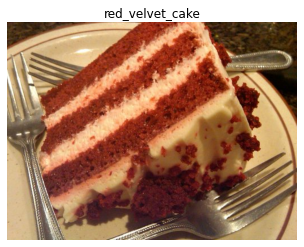

In [18]:
plt.imshow(image.numpy())
plt.title(class_names[label.numpy()])
plt.axis(False)

## Create preprocessing functions to prepare our data
From the above data exploration we notice:  
1.  The labels are not one hot encoded
2.  The images are not normalized
3.  Images have uint8 datatype.
4.  Images are of multiple different shapes.
5.  Data is not batched.



### Resize and convert to `float32`
Since we will be using `EfficientNetB0` which internally scales data hence we don't need to scale during preprocessing phase.  

We'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize)
* Converts an input image tensor's current datatype to `tf.float32` using [`tf.cast()`](https://www.tensorflow.org/api_docs/python/tf/cast)


In [19]:
# Function to resize images and convert to 'float32'
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  preprocessed_image = tf.cast(image, dtype = 'float32')
  # preprocessed_image = preprocessed_image/255 # If using model that requires rescaling
  preprocessed_image = tf.image.resize(image, size = [img_shape, img_shape])
  return preprocessed_image, label # need to return in (float32_image, tuple) format

In [20]:
pp_image = preprocess_img(image, label)

In [21]:
pp_image

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[6.4127548e+01, 3.4127552e+01, 8.8418369e+00],
         [6.8734695e+01, 3.5831631e+01, 1.6688776e+01],
         [6.6076530e+01, 3.2367348e+01, 2.0857143e+01],
         ...,
         [5.9306114e+01, 4.1877586e+01, 1.1449058e+01],
         [5.1806061e+01, 3.5806061e+01, 1.0474433e+01],
         [4.2127460e+01, 2.5357038e+01, 5.7397289e+00]],
 
        [[6.7168365e+01, 3.9168369e+01, 1.7239796e+01],
         [7.4852043e+01, 4.4265308e+01, 2.4061226e+01],
         [7.9525513e+01, 4.7596939e+01, 3.2382652e+01],
         ...,
         [5.4673378e+01, 3.5214241e+01, 4.8724260e+00],
         [4.5790714e+01, 2.8510088e+01, 2.8520007e+00],
         [3.3576538e+01, 1.5433681e+01, 0.0000000e+00]],
 
        [[6.7137756e+01, 3.9923470e+01, 2.0494898e+01],
         [7.6785713e+01, 4.9571430e+01, 2.8683674e+01],
         [7.8377556e+01, 4.9734695e+01, 2.8591839e+01],
         ...,
         [5.2734596e+01, 3.1306114e+01, 9.1827452e-02],


In [22]:
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {pp_image[0][:2]}...,\nShape: {pp_image[0].shape},\nDatatype: {pp_image[0].dtype}")

Image before preprocessing:
 [[[64 34  8]
  [64 34  8]
  [69 37 16]
  ...
  [51 35 10]
  [47 30 10]
  [44 27  7]]

 [[65 35 11]
  [64 34 10]
  [69 38 17]
  ...
  [41 25  0]
  [36 20  0]
  [34 17  0]]]...,
Shape: (384, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[64.12755   34.127552   8.841837 ]
  [68.734695  35.83163   16.688776 ]
  [66.07653   32.367348  20.857143 ]
  ...
  [59.306114  41.877586  11.449058 ]
  [51.80606   35.80606   10.474433 ]
  [42.12746   25.357038   5.739729 ]]

 [[67.168365  39.16837   17.239796 ]
  [74.85204   44.26531   24.061226 ]
  [79.52551   47.59694   32.382652 ]
  ...
  [54.673378  35.21424    4.872426 ]
  [45.790714  28.510088   2.8520007]
  [33.576538  15.433681   0.       ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


### Batch and preprare dataset
Now we need to batchify out data.  
🟢 [Important]: optimize data pipeline 🔽   
     
We have to turn it into batches. because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU or CPU.

To do this in effective way, we're going to be leveraging a number of methods from the [`tf.data` API](https://www.tensorflow.org/api_docs/python/tf/data).


In [23]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train data and turn it into batches and prefetch it (load faster)
train_data = train_data.shuffle(buffer_size = 2000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle test data and turn it into batches and prefetch it
test_data = test_data.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.  
Saving model checkpoints is also useful to revert back to base model if fine tuning doesn't work.  

In [25]:
# Create tensorboard callback
from helper_functions import create_tensorboard_callback

# Create checkpoint callback
checkpoint_path = "/content/drive/MyDrive/Food_Classification/saved_models/food_vision.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = 'val_acc',
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose = 0) # don't print any info while saving model


In [26]:
tf.__version__

'2.4.1'

## Setup mixed precision training  
🟢 [Important]: Mixed Precision 🔽  


In [27]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [28]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [29]:
# !pip install tensorflow==2.4.1

In [30]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create a functional model
inputs = layers.Input(shape = input_shape, name = 'input_layer')
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names), name = "final_dense")(x)
outputs = layers.Activation("softmax", dtype = tf.float32, name = 'softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), # `SparseCategoricalCrossentropy` as labels not one hot encoded
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

16711680/16705208 [==============================] - 0s 0us/step


In [31]:
len(class_names)

101

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
final_dense (Dense)          (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


### Checking layer dtype policies (are we using mixed preision)

In [33]:
# Checking layer dtype policies
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
final_dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [34]:
# Checking layer dtype policies for base model
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <

## Fit the feature extraction model


In [61]:
FEATURE_EXTRACTION_EPOCHS = 3

In [35]:
feature_extraction_history = model.fit(train_data, 
                              steps_per_epoch = len(train_data),
                              validation_data = test_data,
                              validation_steps = int(0.15 * len(train_data)),
                              epochs = FEATURE_EXTRACTION_EPOCHS,
                              callbacks = [create_tensorboard_callback(dir_name = '/content/drive/MyDrive/Food_Classification/tensorboard',
                                                                      experiment_name = 'EfficientNetB0_Food_Vision_Feature_Extraction'),
                                          model_checkpoint])

Saving TensorBoard log files to: /content/drive/MyDrive/Food_Classification/tensorboard/EfficientNetB0_Food_Vision_Feature_Extraction/20210530-151049
Epoch 1/3
2368/2368 [==============================] - 251s 89ms/step - loss: 2.3209 - accuracy: 0.4670 - val_loss: 1.2299 - val_accuracy: 0.6758


Epoch 2/3
2368/2368 [==============================] - 187s 77ms/step - loss: 1.3189 - accuracy: 0.6603 - val_loss: 1.1488 - val_accuracy: 0.6888


Epoch 3/3
2368/2368 [==============================] - 192s 78ms/step - loss: 1.1486 - accuracy: 0.7002 - val_loss: 1.1042 - val_accuracy: 0.6964


In [36]:
len(train_data)

2368

In [37]:
train_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [38]:
results_feature_extraction = model.evaluate(test_data)
results_feature_extraction

790/790 [==============================] - 52s 66ms/step - loss: 1.0994 - accuracy: 0.7012


[1.0994489192962646, 0.7011881470680237]

## Save the whole model to file


In [39]:
## Saving model to Google Drive (optional)

# Create save path to drive 
save_dir = "/content/drive/MyDrive/Food_Classification/saved_models/efficientnetb0_feature_extract_model_mixed_precision/"
# os.makedirs(save_dir) # Make directory if it doesn't exist

# Save model
model.save(save_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food_Classification/saved_models/efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food_Classification/saved_models/efficientnetb0_feature_extract_model_mixed_precision/assets


And again, we can check whether or not our model saved correctly by loading it in and evaluating it.

In [40]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

Loading a `SavedModel` also retains all of the underlying layers `dtype_policy` (we want them to be `"mixed_float16"`).

In [41]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [42]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 48s 59ms/step - loss: 1.0994 - accuracy: 0.7012


[1.0994486808776855, 0.7011881470680237]

In [44]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
import numpy as np
assert np.isclose(results_feature_extraction, results_loaded_saved_model).all()

That's what we want! Our loaded model performing as it should.


## Fine Tuning

In [46]:
loaded_base_model = loaded_saved_model.layers[1]

In [47]:
# Fine tune all layers
loaded_base_model.trainable = True
# for layer in loaded_base_model.layers[:-10]:
#   layer.trainable = False


In [48]:
for layer in loaded_base_model.layers:
  print(layer.name, layer.trainable)


input_1 True
rescaling True
normalization True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn True
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand_bn True
block2b_expand_activation True
block2b_dwconv True
block2b_bn True
block2b_activation True
block2b_se_squeeze True
block2b_se_reshape True
block2b_se_reduce True
block2b_se_expand True
block2b_se_excite True
block2b_project_conv True
block2b_project_bn True
block2b_drop True
bloc

In [49]:
for layer in loaded_saved_model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling2d True
final_dense True
softmax_float32 True


In [57]:
# Setup EarlyStopping callback 
fine_tuning_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience=3) 

# Create ModelCheckpoint callback to save best model during fine-tuning
fine_tuning_checkpoint_path = "/content/drive/MyDrive/Food_Classification/saved_models/fine_tune_checkpoints/"
fine_tuning_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(fine_tuning_checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

🟢[Important]: `ReduceLROnPlateau` Callback 🔽  
  
Learning rate is the most important model hyperparameter you can tune.

`ReduceLROnPlateau` callback helps to tune the learning rate.

the `ReduceLROnPlateau` callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

In [58]:
# Creating learning rate reduction callback
fine_tuning_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [59]:
loaded_saved_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                           optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                           metrics = ['accuracy'])

In [62]:
FINE_TUNING_EPOCHS = FEATURE_EXTRACTION_EPOCHS + 100

In [64]:
fine_tune_history = loaded_saved_model.fit(train_data, 
                       steps_per_epoch = len(train_data),
                       validation_data = test_data,
                       validation_steps = int(0.15 * len(test_data)),
                       initial_epoch = FEATURE_EXTRACTION_EPOCHS,
                       epochs = FINE_TUNING_EPOCHS,
                       callbacks = [fine_tuning_early_stopping,
                                    fine_tuning_model_checkpoint,
                                    fine_tuning_reduce_lr,
                                    create_tensorboard_callback(dir_name = '/content/drive/MyDrive/Food_Classification/tensorboard',
                                                                experiment_name = 'EfficientNetB0_Food_Vision_Fine_tune_all_layers')])

Saving TensorBoard log files to: /content/drive/MyDrive/Food_Classification/tensorboard/EfficientNetB0_Food_Vision_Fine_tune_all_layers/20210530-154451
Epoch 4/103
2368/2368 [==============================] - 307s 124ms/step - loss: 0.9785 - accuracy: 0.7371 - val_loss: 0.8226 - val_accuracy: 0.7728
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food_Classification/saved_models/fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food_Classification/saved_models/fine_tune_checkpoints/assets


Epoch 5/103
2368/2368 [==============================] - 292s 122ms/step - loss: 0.5936 - accuracy: 0.8357 - val_loss: 0.7890 - val_accuracy: 0.7889
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food_Classification/saved_models/fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food_Classification/saved_models/fine_tune_checkpoints/assets


Epoch 6/103
2368/2368 [==============================] - 291s 121ms/step - loss: 0.3371 - accuracy: 0.9067 - val_loss: 0.8564 - val_accuracy: 0.7805
Epoch 7/103
2368/2368 [==============================] - 291s 122ms/step - loss: 0.1662 - accuracy: 0.9525 - val_loss: 0.9111 - val_accuracy: 0.7876

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 8/103
2368/2368 [==============================] - 290s 121ms/step - loss: 0.0460 - accuracy: 0.9898 - val_loss: 1.0471 - val_accuracy: 0.8043


In [66]:
# Save model to Google Drive
loaded_saved_model.save("/content/drive/MyDrive/Food_Classification/saved_models/efficientnetb0_fine_tuned_food_vision_mixed_precision/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food_Classification/saved_models/efficientnetb0_fine_tuned_food_vision_mixed_precision/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Food_Classification/saved_models/efficientnetb0_fine_tuned_food_vision_mixed_precision/assets


In [67]:
results_fine_tuning = loaded_saved_model.evaluate(test_data)
results_fine_tuning

790/790 [==============================] - 50s 63ms/step - loss: 1.0734 - accuracy: 0.8006


[1.0733779668807983, 0.8005940318107605]

**Project Successful!!**    
We obtained better results than the DeepFood paper!

Using the [`EfficientNetB4`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB4) model (a larger version of `EfficientNetB0`) can produce even better results.  

## View training results on TensorBoard


In [68]:
!tensorboard dev upload --logdir /content/drive/MyDrive/Food_Classification/tensorboard/EfficientNetB0_Food_Vision_Fine_tune_all_layers \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for all layers fine-tuned EfficientNetB0 on Food101 Data" \
  --one_shot

2021-05-30 16:12:25.128291: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/drive/MyDrive/Food_Classification/tensorboard/EfficientNetB0_Food_Vision_Fine_tune_all_layers

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l44

Viewing at our [model's training curves on TensorBoard.dev](https://tensorboard.dev/experiment/2KINdYxgSgW2bUg7dIvevw/), it looks like our fine-tuning model gains boost in performance but starts to overfit as training goes on.

See the training curves on TensorBoard.dev here: https://tensorboard.dev/experiment/2KINdYxgSgW2bUg7dIvevw/

To fix this, in future experiments, we might try things like:
* A different iteration of `EfficientNet` (e.g. `EfficientNetB4` instead of `EfficientNetB0`).
* Unfreezing less layers of the base model and training them rather than unfreezing the whole base model in one go.



In [69]:
# View past TensorBoard experiments
!tensorboard dev list

2021-05-30 16:23:45.902385: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/kmIRzNrrTeqNXKq0zQ2f8A/
	Name                 Fine-tuning EfficientNetB0 on all Food101 Data
	Description          Training results for all layers fine-tuned EfficientNetB0 on Food101 Data
	Id                   kmIRzNrrTeqNXKq0zQ2f8A
	Created              2021-05-30 16:23:42 (9 seconds ago)
	Updated              2021-05-30 16:23:43 (8 seconds ago)
	Runs                 2
	Tags                 3
	Scalars              20
	Tensor bytes         0
	Binary object bytes  1272539
https://tensorboard.dev/experiment/zEeuQaYWRIy7hPe16FWnUA/
	Name                 Transfer Learning Experiments with 10 Food 101 classes
	Description  

In [71]:
# Delete past TensorBoard experiments
# !tensorboard dev delete --experiment_id zEeuQaYWRIy7hPe16FWnUA

2021-05-30 16:25:20.439363: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Deleted experiment zEeuQaYWRIy7hPe16FWnUA.
